In [2]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [3]:
data = pd.read_csv('./data/220114/220114 kpeb1.csv', parse_dates = True)

In [4]:
data

,DateTime,HeatPump(W),Total_Consumption(W),Total_Production(W),Pv1_Supply(W),Pv2_Supply(W)
0,2022-01-15 11:44:00,195,12431,32070,11642,20428
1,2022-01-15 11:43:00,195,12392,32054,11642,20412
2,2022-01-15 11:42:00,193,12574,32198,11692,20506
3,2022-01-15 11:41:00,196,13270,32290,11732,20557
4,2022-01-15 11:40:00,195,13188,32384,11766,20619
...,...,...,...,...,...,...
278433,2021-06-16 13:37:00,0,0,0,0,0
278434,2021-06-16 13:36:00,0,0,0,0,0
278435,2021-06-16 13:35:00,0,0,0,0,0
278436,2021-06-16 13:34:00,0,0,0,0,0


In [5]:
all_features = data.columns.tolist()
print(all_features)

['DateTime', 'HeatPump(W)', 'Total_Consumption(W)', 'Total_Production(W)', 'Pv1_Supply(W)', 'Pv2_Supply(W)']


In [7]:
df_kpeb1 = pd.DataFrame()
df_kpeb1['Time'] = data['DateTime']
df_kpeb1['Cons_kpeb1(W)'] = data['Total_Consumption(W)']
df_kpeb1['Prod_kpeb1(W)'] = data['Total_Production(W)']

df_kpeb1.head()


,Time,Cons_kpeb1(W),Prod_kpeb1(W)
0,2022-01-15 11:44:00,12431,32070
1,2022-01-15 11:43:00,12392,32054
2,2022-01-15 11:42:00,12574,32198
3,2022-01-15 11:41:00,13270,32290
4,2022-01-15 11:40:00,13188,32384


In [8]:
df_kpeb1['Time'] = pd.to_datetime(df_kpeb1['Time'])

In [9]:
df_kpeb1=df_kpeb1[(df_kpeb1['Time']>='2021-09-13 00:00:00')]
df_kpeb1=df_kpeb1[(df_kpeb1['Time']<'2022-01-01 00:00:00')]

In [10]:
df_kpeb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142393 entries, 20864 to 163256
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Time           142393 non-null  datetime64[ns]
 1   Cons_kpeb1(W)  142393 non-null  int64         
 2   Prod_kpeb1(W)  142393 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.3 MB


In [11]:
df_kpeb1['Cons_kpeb1(W)'] = df_kpeb1['Cons_kpeb1(W)'].astype(float)
df_kpeb1['Prod_kpeb1(W)'] = df_kpeb1['Prod_kpeb1(W)'].astype(float)

In [12]:
df_kpeb1=df_kpeb1.set_index('Time')
df_kpeb1=df_kpeb1.resample('1T').mean()

In [13]:
df_kpeb1['Cons_acc_kpeb1(Wh)'] = df_kpeb1['Cons_kpeb1(W)'].cumsum()*60/3600
df_kpeb1['Prod_acc_kpeb1(Wh)'] = df_kpeb1['Prod_kpeb1(W)'].cumsum()*60/3600

In [14]:
df_kpeb1['denominator'] = df_kpeb1.loc[:,['Cons_kpeb1(W)','Prod_kpeb1(W)']].min(axis=1)
df_kpeb1['denominator_acc'] = df_kpeb1.loc[:,['Cons_acc_kpeb1(Wh)','Prod_acc_kpeb1(Wh)']].min(axis=1)

In [15]:
df_kpeb1['SCF'] = df_kpeb1['denominator']/df_kpeb1['Prod_kpeb1(W)']
df_kpeb1['LCF'] = df_kpeb1['denominator']/df_kpeb1['Cons_kpeb1(W)']

In [16]:
df_kpeb1['SCF_acc'] = df_kpeb1['denominator_acc']/df_kpeb1['Prod_acc_kpeb1(Wh)']
df_kpeb1['LCF_acc'] = df_kpeb1['denominator_acc']/df_kpeb1['Cons_acc_kpeb1(Wh)']
df_kpeb1['self_sustain'] = df_kpeb1['Prod_acc_kpeb1(Wh)']/df_kpeb1['Cons_acc_kpeb1(Wh)']
df_kpeb1['Avg_SCF&LCF'] = (df_kpeb1['SCF_acc']+df_kpeb1['LCF_acc'])/2

In [17]:
df_kpeb1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158400 entries, 2021-09-13 00:00:00 to 2021-12-31 23:59:00
Freq: T
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Cons_kpeb1(W)       142393 non-null  float64
 1   Prod_kpeb1(W)       142393 non-null  float64
 2   Cons_acc_kpeb1(Wh)  142393 non-null  float64
 3   Prod_acc_kpeb1(Wh)  142393 non-null  float64
 4   denominator         142393 non-null  float64
 5   denominator_acc     142393 non-null  float64
 6   SCF                 61323 non-null   float64
 7   LCF                 142386 non-null  float64
 8   SCF_acc             142043 non-null  float64
 9   LCF_acc             142393 non-null  float64
 10  self_sustain        142393 non-null  float64
 11  Avg_SCF&LCF         142043 non-null  float64
dtypes: float64(12)
memory usage: 15.7 MB


In [18]:
df_kpeb1

,Cons_kpeb1(W),Prod_kpeb1(W),Cons_acc_kpeb1(Wh),Prod_acc_kpeb1(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,
2021-09-13 00:00:00,5695.0,0.0,9.491667e+01,0.00,0.0,0.00,NaN,0.0,NaN,0.000000,0.000000,NaN
2021-09-13 00:01:00,5284.0,0.0,1.829833e+02,0.00,0.0,0.00,NaN,0.0,NaN,0.000000,0.000000,NaN
2021-09-13 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:03:00,5551.0,0.0,2.755000e+02,0.00,0.0,0.00,NaN,0.0,NaN,0.000000,0.000000,NaN
2021-09-13 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:55:00,7203.0,0.0,2.367274e+07,12356196.55,0.0,12356196.55,NaN,0.0,1.0,0.521959,0.521959,0.760979
2021-12-31 23:56:00,8477.0,0.0,2.367288e+07,12356196.55,0.0,12356196.55,NaN,0.0,1.0,0.521956,0.521956,0.760978
2021-12-31 23:57:00,9830.0,0.0,2.367304e+07,12356196.55,0.0,12356196.55,NaN,0.0,1.0,0.521952,0.521952,0.760976


In [ ]:
df_kpeb1.to_csv('./211109_kpeb1.csv')

# Scatter plotting

In [ ]:
fig, ax = plt.subplots(figsize=(18,50))


for i in range(len(df_kpeb1.columns)):
    plt.subplot(len(df_kpeb1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kpeb1.columns[i]
    plt.scatter(x=df_kpeb1['Time'], y=df_kpeb1[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

# Line plotting

In [ ]:
df_kpeb1=df_kpeb1.set_index('Time')

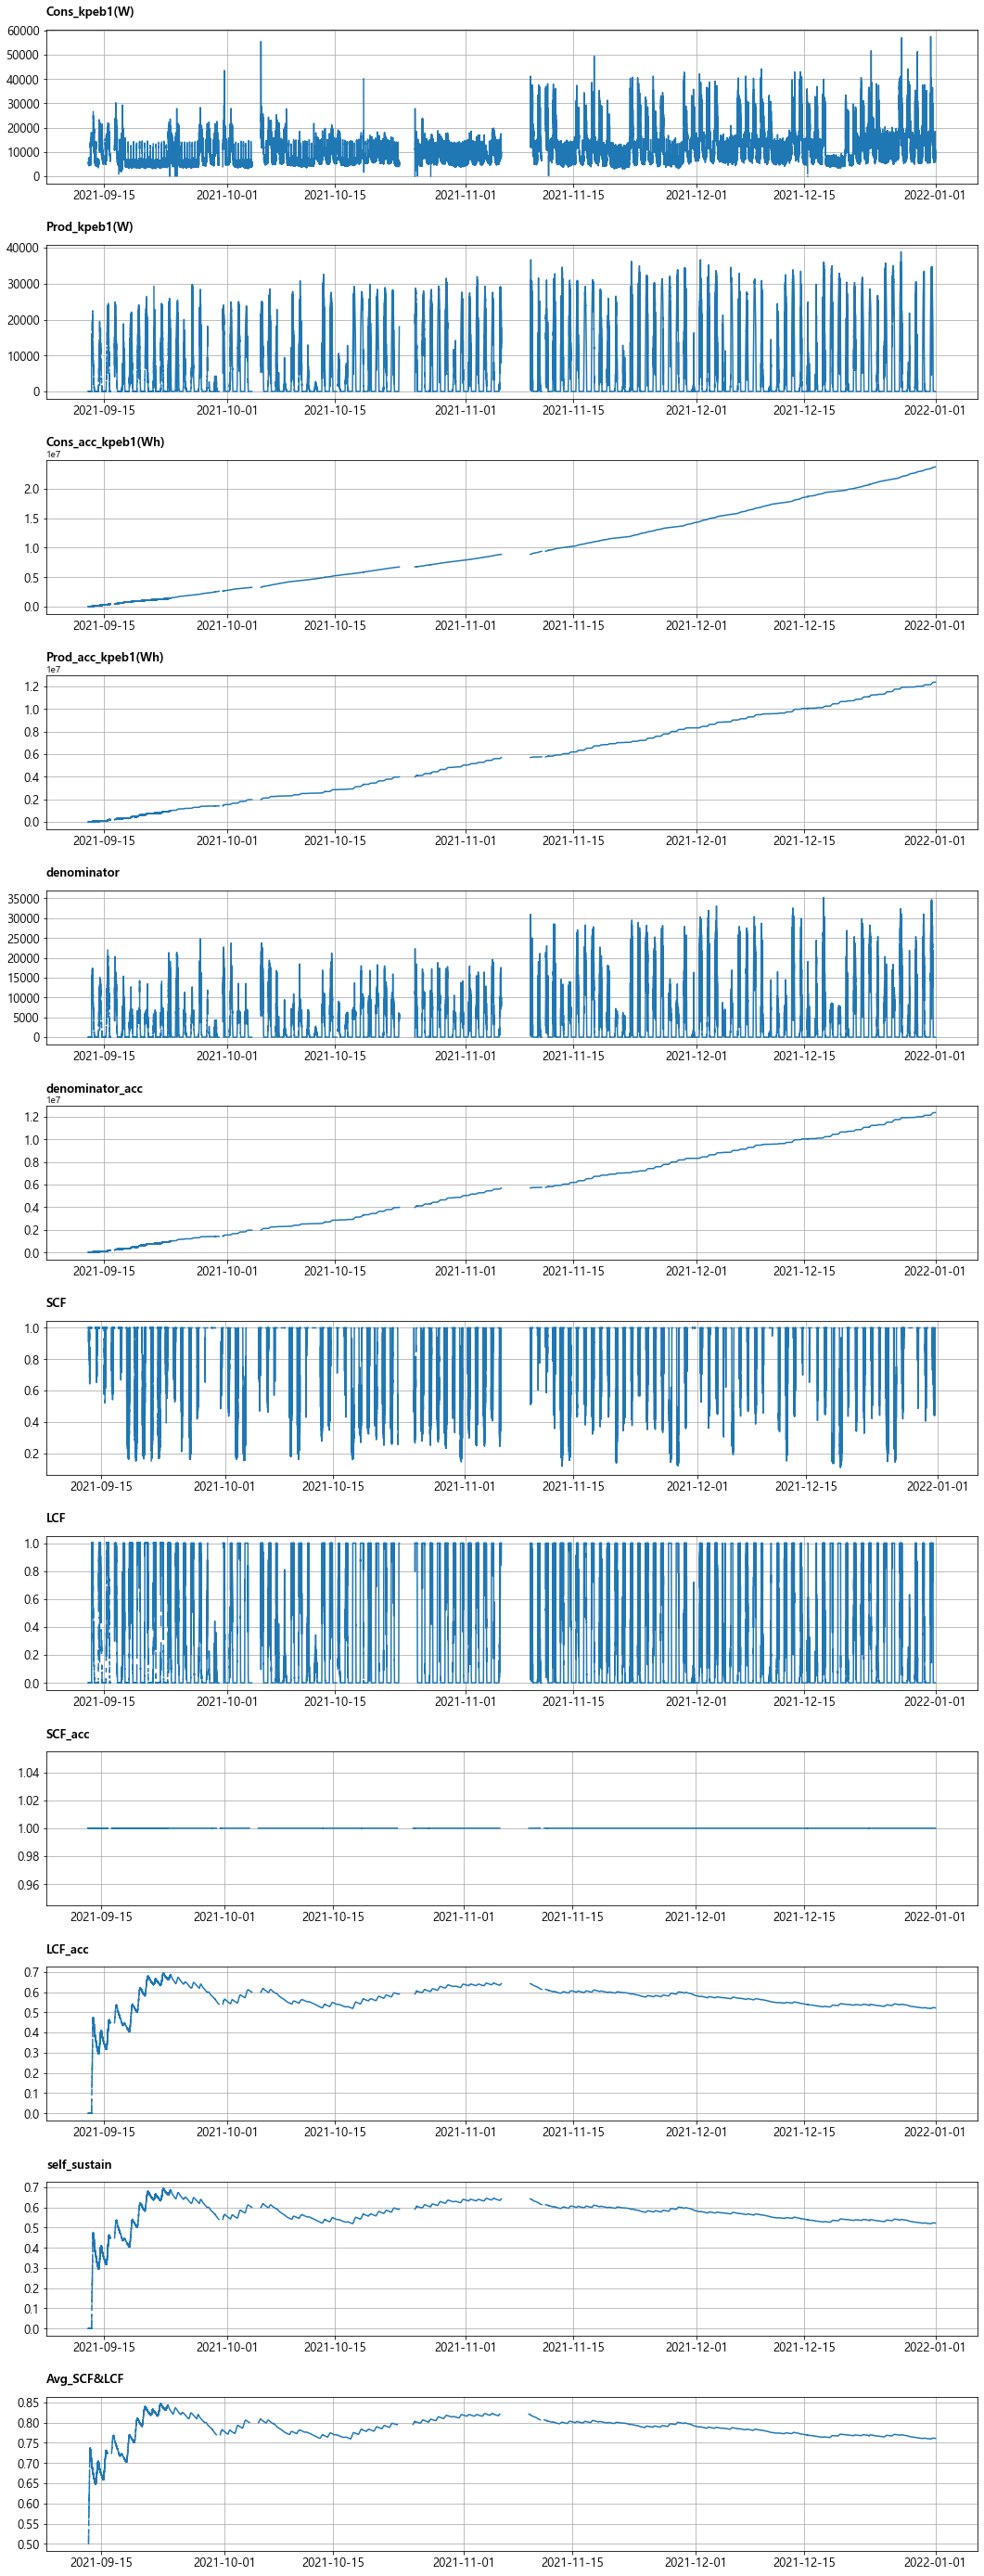

In [19]:
fig, ax = plt.subplots(figsize=(18,50))

for i in range(len(df_kpeb1.columns)):
    plt.subplot(len(df_kpeb1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpeb1.columns[i]
    plt.plot(df_kpeb1[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
#     plt.xlim(pd.Timestamp('2020-11-01'), pd.Timestamp('2021-08-31'))    
    plt.grid(True)
plt.show()
fig.tight_layout()